# XGBoost - Closed-world Scenario (Extra Features)

**Feature 소스**: extra_credit/features/extra_mon_features.pkl
- **시나리오**: Monitored 사이트 간 분류 (95개 클래스)
- **Extra Features 사용**: 모든 17개 extra features 사용


## 1. 라이브러리 및 데이터 로드


In [ ]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("라이브러리 로드 완료")


라이브러리 로드 완료


In [ ]:
# Load extra monitored features
print("Extra Monitored 데이터 로드 중...")

# numpy 2.x 환경에서 예전 버전으로 저장된 pickle 호환을 위한 패치
import sys
import numpy.core.numeric as _numeric
sys.modules.setdefault('numpy._core.numeric', _numeric)

mon_features = pd.read_pickle('../features/extra_mon_features.pkl')

print(f"데이터 형태: {mon_features.shape}")
print(f"클래스 수: {len(mon_features['label'].unique())}")
print(f"샘플 수: {len(mon_features)}")
print("\n데이터 미리보기:")
print(mon_features.head())
print("\nFeature 목록:")
feature_cols = [col for col in mon_features.columns if col != 'label']
print(feature_cols)


Extra Monitored 데이터 로드 중...
데이터 형태: (19000, 18)
클래스 수: 95
샘플 수: 19000

데이터 미리보기:
   total_transmission_time  std_inter_packet_time  avg_outgoing_burst_size  \
0                 6.867427               0.033406                 1.962963   
1                 6.560100               0.061620                 1.928571   
2                 9.721923               0.048246                 2.717949   
3                 9.673480               0.103539                 2.320000   
4                 8.870500               0.065075                 1.685714   

   avg_incoming_burst_size  num_outgoing_packets  incoming_packet_ratio  \
0                13.777778                 106.0               0.875294   
1                26.857143                  27.0               0.933002   
2                27.179487                 106.0               0.909091   
3                35.307692                  58.0               0.940574   
4                28.472222                  59.0               0.945572   


## 2. Feature 선택


In [ ]:
# 모든 extra features 사용 (label 제외)
selected_features = feature_cols

print(f"선택된 Feature 수: {len(selected_features)}")
print("\nFeature 목록:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i:2d}. {feature}")


선택된 Feature 수: 17

Feature 목록:
 1. total_transmission_time
 2. std_inter_packet_time
 3. avg_outgoing_burst_size
 4. avg_incoming_burst_size
 5. num_outgoing_packets
 6. incoming_packet_ratio
 7. outgoing_packet_ratio
 8. cumul_packets_10pct
 9. cumul_packets_30pct
10. outgoing_order_skew
11. incoming_order_skew
12. cumul_max
13. bigram_OO
14. num_incoming_first_30
15. outgoing_first_30
16. avg_incoming_order_first_30
17. avg_outgoing_order_first_30


## 3. 데이터 준비


In [ ]:
# Closed-world: monitored 사이트만 사용, label로 분류
X = mon_features[selected_features]
y = mon_features['label'].values

print(f"전체 샘플 수: {X.shape[0]}")
print(f"Feature 수: {X.shape[1]}")
print(f"클래스 수: {len(np.unique(y))}")
print(f"클래스 범위: {min(y)} ~ {max(y)}")

# 클래스별 샘플 수 확인
class_counts = pd.Series(y).value_counts().sort_index()
print(f"\n클래스별 샘플 수 (처음 10개):")
print(class_counts.head(10))
print(f"평균 샘플 수: {class_counts.mean():.1f}")

# 데이터 분할 (80% 훈련, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n훈련 데이터: {X_train.shape[0]} 샘플")
print(f"테스트 데이터: {X_test.shape[0]} 샘플")


전체 샘플 수: 19000
Feature 수: 17
클래스 수: 95
클래스 범위: 0 ~ 94

클래스별 샘플 수 (처음 10개):
0    200
1    200
2    200
3    200
4    200
5    200
6    200
7    200
8    200
9    200
Name: count, dtype: int64
평균 샘플 수: 200.0

훈련 데이터: 15200 샘플
테스트 데이터: 3800 샘플


## 4. XGBoost 모델 훈련 및 평가


In [ ]:
# 최적 하이퍼파라미터
best_params = {
    'n_estimators': 200,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'objective': 'multi:softprob',
    'num_class': 95,
    'eval_metric': 'mlogloss'
}

print("최적 하이퍼파라미터:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# XGBoost 모델 훈련
print("\nXGBoost 모델 훈련 중...")
xgb_clf = XGBClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1
)

xgb_clf.fit(X_train, y_train)
print("모델 훈련 완료!")

# 예측
y_pred = xgb_clf.predict(X_test)

# 성능 지표 계산
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("\n" + "="*60)
print("CLOSED-WORLD XGBOOST 결과 (Extra Features)")
print("="*60)
print(f"정확도 (Accuracy): {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")
print("="*60)


최적 하이퍼파라미터:
  n_estimators: 200
  max_depth: 6
  learning_rate: 0.1
  subsample: 0.8
  colsample_bytree: 0.8
  reg_alpha: 0.1
  reg_lambda: 1.0
  objective: multi:softprob
  num_class: 95
  eval_metric: mlogloss

XGBoost 모델 훈련 중...
모델 훈련 완료!

CLOSED-WORLD XGBOOST 결과 (Extra Features)
정확도 (Accuracy): 0.2182 (21.82%)
F1-Score (Macro): 0.2149
F1-Score (Weighted): 0.2149



Feature 중요도 (상위 10개):
                feature  importance
   num_outgoing_packets    0.075296
      outgoing_first_30    0.075262
    cumul_packets_30pct    0.072961
total_transmission_time    0.069498
  std_inter_packet_time    0.069033
              bigram_OO    0.063211
  outgoing_packet_ratio    0.061809
  num_incoming_first_30    0.058651
  incoming_packet_ratio    0.057480
              cumul_max    0.053486


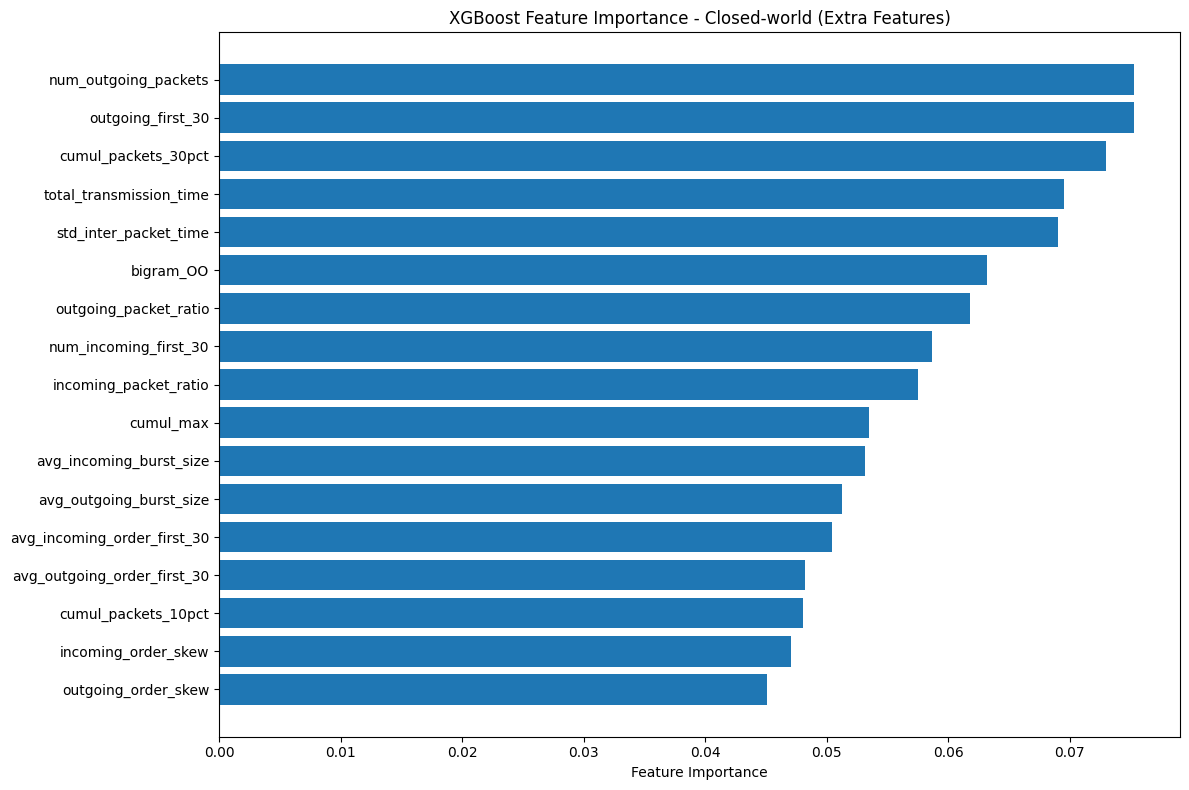

In [ ]:
# Feature 중요도 분석
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': xgb_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature 중요도 (상위 10개):")
print(feature_importance.head(10).to_string(index=False))

# Feature 중요도 시각화
plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance - Closed-world (Extra Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
